In [2]:
import pandas as pd
import numpy as np

##### Importing Unseen Dataset

In [3]:
test_df=pd.read_csv('Test_dataset.csv', nrows=50000)

In [4]:
test_df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amt                         50000 non-null  float64
 1   city_pop                    50000 non-null  int64  
 2   trans_month                 50000 non-null  int64  
 3   Weekday                     50000 non-null  int64  
 4   category_food_dining        50000 non-null  int64  
 5   category_gas_transport      50000 non-null  int64  
 6   category_grocery_net        50000 non-null  int64  
 7   category_grocery_pos        50000 non-null  int64  
 8   category_health_fitness     50000 non-null  int64  
 9   category_home               50000 non-null  int64  
 10  category_kids_pets          50000 non-null  int64  
 11  category_misc_net           50000 non-null  int64  
 12  category_misc_pos           50000 non-null  int64  
 13  category_personal_care      500

###### Examining combined approach on 50,000 rows

In [6]:
data=test_df.iloc[:50000,:-1]
y_test=test_df.iloc[:50000:,-1]

In [7]:
data=np.array(data)

In [8]:
from tensorflow import keras

##### Loading saved LSTM model

In [9]:
#Load the model
model = keras.models.load_model('LSTM_model.h5')

In [10]:
data_test_reshaped=data.reshape(data.shape[0],1, data.shape[1])

In [11]:
data_test_reshaped.shape

(50000, 1, 26)

In [12]:
y_pred = model.predict(data_test_reshaped)

1563/1563 [==============================] - 10s 5ms/step


In [13]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [14]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_binary)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_binary)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_binary)
print('Recall: %f' % recall)

Accuracy: 0.986560
Precision: 0.989038
Recall: 0.984155


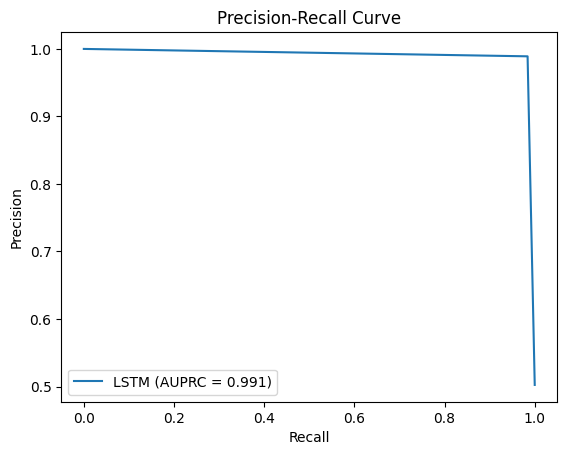

In [15]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_binary)
auprc = auc(recall, precision)
plt.plot(recall, precision, label='LSTM (AUPRC = {:.3f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

##### Inference
* LSTM has performed well on unseen Test dataset with good precision and recall 

##### Adaptive Random Forest 

In [17]:
import pickle
with open ("ARF_evaluator (1).pkl","rb" ) as file :
    evaluator=pickle.load(file)

In [19]:
arf_y_pred=evaluator.predict(data)

In [20]:
arf_y_pred

[array([1, 1, 1, ..., 1, 0, 0])]

##### Combined Predictions

In [21]:
y_pred_binary.shape

(50000, 1)

In [22]:
arf_predictions=np.array(arf_y_pred[0])

In [23]:
# Reshape arf_predictions to match the shape of y_pred_binary
Arf_predtn = np.reshape(arf_predictions, (-1, 1))

##### Performing Weighted Voting

In [31]:
lstm_weight = 0.6
arf_weight = 0.4
# Apply average weighted voting
combined_predictions = (lstm_weight * y_pred_binary + arf_weight * Arf_predtn  / (lstm_weight + arf_weight))

In [32]:
combined_predictions

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

#### Examining Misclassifications

In [33]:
def create_table_diff(target, y_pred):
    target = np.reshape(target, -1)
    y_pred = np.reshape(y_pred, -1)
    return pd.DataFrame({"actual values": target,
                         "predicted values": y_pred,
                         "diff": np.abs(target - y_pred)})

In [34]:
df_pred=create_table_diff(y_test,combined_predictions)

In [35]:
df_pred[df_pred['diff'] == 1]

,actual values,predicted values,diff
224,1,0.0,1.0
379,1,0.0,1.0
515,1,0.0,1.0
800,1,0.0,1.0
930,1,0.0,1.0
...,...,...,...
49646,1,0.0,1.0
49877,1,0.0,1.0
49927,1,0.0,1.0
49928,1,0.0,1.0


##### Out of 50,000 rows, combined model is giving 397 misclassifications i.e approximately 0.7%

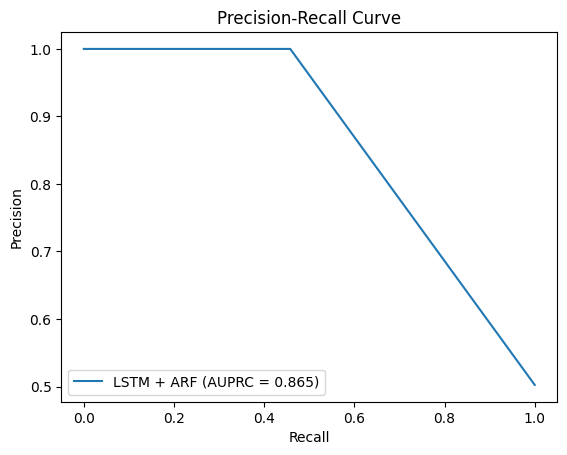

In [36]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, combined_predictions.astype(int))
auprc = auc(recall, precision)
plt.plot(recall, precision, label='LSTM + ARF (AUPRC = {:.3f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()